In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
# !pip install category_encoders
# from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

c:\Users\ytchi\anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ytchi\anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\ytchi\anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Preprocessing

In [2]:
# データロード
df = pd.read_csv('vgsales.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
# Yearの欠損数
len(df[df['Year'].isna()])

271

In [5]:
# Publisherが欠損しているレコードのindex
pub_na_idx = df[df['Publisher'].isna()].index
# Yearが欠損しているレコードのindex
year_na_idx = df[df['Year'].isna()].index

In [6]:
# Publisherの欠損を"NaN"で埋める
df[['Publisher']] = df[['Publisher']].fillna("NaN")

In [7]:
# 複数のカラムを同時に埋めることも可能
df = pd.read_csv('vgsales.csv')
df.fillna({'Publisher': "NaN", 'Year': df['Year'].median()}, inplace=True)
df.iloc[year_na_idx][:4]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,Madden NFL 2004,PS2,2007.0,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23
377,378,FIFA Soccer 2004,PS2,2007.0,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49
431,432,LEGO Batman: The Videogame,Wii,2007.0,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
470,471,wwe Smackdown vs. Raw 2006,PS2,2007.0,Fighting,NaN,1.57,1.02,0.00,0.41,3.00


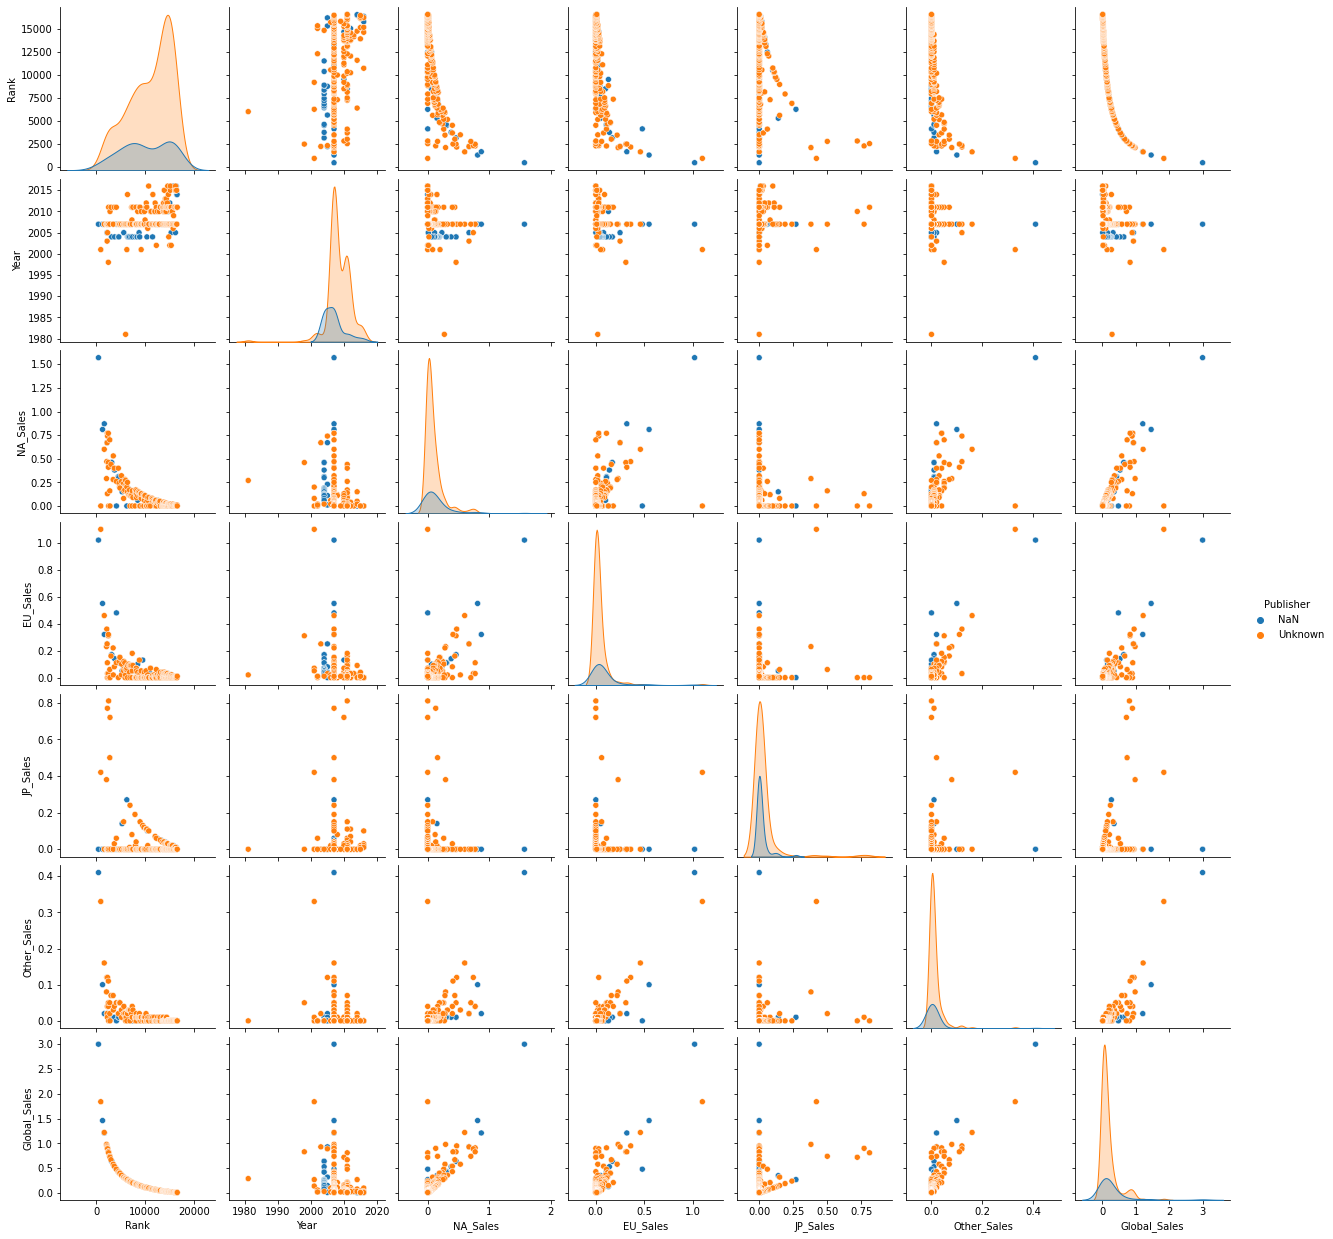

In [8]:
# Publisherの欠損とUnkownの分布の違いを確認
pub_nan_df = df[df['Publisher']=='NaN']
pub_unknown_df = df[df['Publisher']=='Unknown']
pub_missing_df = pd.concat([pub_nan_df, pub_unknown_df])
sns.pairplot(pub_missing_df, hue='Publisher')

In [9]:
# SimpleImputerでも欠損値代入が可能
# Yearに中央値，Publisherには最頻値を入れる例
df = pd.read_csv('vgsales.csv')
imputer = SimpleImputer(strategy='median')
df['Year'] = imputer.fit_transform(df[['Year']])
imputer = SimpleImputer(strategy='most_frequent')
df[['Publisher']] = imputer.fit_transform(df[['Publisher']])

In [10]:
# Platform別にYearの中央値を計算し，その値で欠損値を埋める
df = pd.read_csv('vgsales.csv')
platform_year_dict = df.groupby('Platform').median()['Year'].to_dict()
df['Year'] = df.apply(lambda row: platform_year_dict[row['Platform']] if np.isnan(row['Year']) and (row['Platform'] in platform_year_dict) else row['Year'], axis=1)

In [11]:
# それぞれのPlatformに対応してYearの値が入っている
df.iloc[year_na_idx]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,Madden NFL 2004,PS2,2005.0,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23
377,378,FIFA Soccer 2004,PS2,2005.0,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49
431,432,LEGO Batman: The Videogame,Wii,2009.0,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
470,471,wwe Smackdown vs. Raw 2006,PS2,2005.0,Fighting,NaN,1.57,1.02,0.00,0.41,3.00
607,608,Space Invaders,2600,1982.0,Shooter,Atari,2.36,0.14,0.00,0.03,2.53
...,...,...,...,...,...,...,...,...,...,...,...
16307,16310,Freaky Flyers,GC,2003.0,Racing,Unknown,0.01,0.00,0.00,0.00,0.01
16327,16330,Inversion,PC,2009.0,Shooter,Namco Bandai Games,0.01,0.00,0.00,0.00,0.01
16366,16369,Hakuouki: Shinsengumi Kitan,PS3,2011.0,Adventure,Unknown,0.01,0.00,0.00,0.00,0.01
16427,16430,Virtua Quest,GC,2003.0,Role-Playing,Unknown,0.01,0.00,0.00,0.00,0.01


In [12]:
# 代表値による欠損代入する場合，代表値は学習データを使用して計算する
df = pd.read_csv('vgsales.csv')
# 今回は'JP_Sales' を予測するタスクとする
df.drop('Global_Sales', inplace=True, axis=1) # Global_Salesがあると簡単にJP_Salesを計算できてしまうため
target = 'JP_Sales'
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
platform_year_dict = X_train.groupby('Platform').median()['Year'].to_dict()
X_train['Year'] = X_train.apply(lambda row: platform_year_dict[row['Platform']] if np.isnan(row['Year']) and (row['Platform'] in platform_year_dict) else row['Year'], axis=1)

In [13]:

# テストデータにも同様にplatform_year_dictを使用する
X_test['Year'] = X_test.apply(lambda row: platform_year_dict[row['Platform']] if np.isnan(row['Year']) and (row['Platform'] in platform_year_dict) else row['Year'], axis=1)

In [14]:
X_test

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,Other_Sales
1586,1588,Tom Clancy's Rainbow Six: Vegas,PS3,2007.0,Shooter,Ubisoft,0.47,0.53,0.22
5368,5370,Monster Rancher 4,PS2,2003.0,Simulation,Tecmo Koei,0.08,0.06,0.02
6275,6277,Dynasty Warriors,PS,1997.0,Action,Tecmo Koei,0.09,0.06,0.02
9130,9132,Bravo Air Race,PS,1997.0,Racing,THQ,0.08,0.05,0.01
5759,5761,Football Manager 2016,PC,2015.0,Simulation,Sega,0.00,0.29,0.02
...,...,...,...,...,...,...,...,...,...
6020,6022,FIFA Soccer 13,3DS,2012.0,Action,Electronic Arts,0.06,0.20,0.03
1643,1645,Chocobo no Fushigi Dungeon,PS,1997.0,Role-Playing,SquareSoft,0.00,0.00,0.08
4002,4004,Super Famista 5,SNES,1996.0,Sports,Namco Bandai Games,0.00,0.00,0.00
7259,7261,Pinball Hall of Fame: The Williams Collection,PS3,2009.0,Misc,Crave Entertainment,0.20,0.00,0.02


#### kNNで欠損値代入

In [15]:
# データ準備
df = pd.read_csv('vgsales.csv')
df[['Publisher']] = df[['Publisher']].fillna('NaN')
df.drop("Name", axis=1, inplace=True)
# Yearカラムの欠損をKNNで代入する
target = "Year"
X = df.drop(target, axis=1)
y = df[target]
# 数値カラムのリスト取得(標準化の対象)
num_cols = X.select_dtypes(include=np.number).columns.to_list()
# ダミー変数
X = pd.get_dummies(X, drop_first=True)
# 標準化
X[num_cols] = StandardScaler().fit_transform(X[num_cols])
# YearがNaNのデータはテストデータ，そうでなければ学習データ
test_indexes = df[df['Year'].isna()].index
train_indexes = df[~df['Year'].isna()].index
X_train, X_test = X.iloc[train_indexes], X.iloc[test_indexes]
y_train, y_test = y.iloc[train_indexes], y.iloc[test_indexes]

In [16]:
# kNNのモデルを作って予測値を代入する
knn = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [18]:
# 一つ目のテストデータのkNNのYear予測を確認
df.iloc[X_test.head(1).index]

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23


In [19]:
y_pred[0]

2004.3333333333333

In [23]:
# neighborとして使用されたデータを確認する
neighbors = knn.kneighbors(X_test.head(1))
# neighbors[1][0]には，予測に使用されたデータ(X_train)のindexが格納されているが，
# このindexは学習データX_trainの先頭からのindexである
# (しかし、X_train はXから切り出したため、indexが飛び飛びになっている)
# 一度reset_index()でindexを先頭から振り直して(X_train.reset_index())
# 対象データにアクセスし(X_train.reset_index().loc[neighbors[1][0]])
# ['index']カラムから元のdfのindexを取得する(X_train.reset_index().loc[neighbors[1][0]]['index'])
df.loc[X_train.reset_index().loc[neighbors[1][0]]['index']] 

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
211,212,PS2,2005.0,Sports,Electronic Arts,3.98,0.26,0.01,0.66,4.91
240,241,PS2,2006.0,Sports,Electronic Arts,3.63,0.24,0.01,0.61,4.49
279,280,PS2,2002.0,Sports,Electronic Arts,3.36,0.21,0.01,0.56,4.14


In [26]:
# kNNImputerを使う
imputer = KNNImputer(n_neighbors=3)
imputer.set_output(transform='pandas')
# ダミー変数
df = pd.get_dummies(df, drop_first=True)
# 標準化
df[num_cols] = StandardScaler().fit_transform(df[num_cols])
df_imputed = imputer.fit_transform(df)

In [27]:
df_imputed.iloc[test_indexes]

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
179,-1.694720,2004.333333,4.892293,0.224302,-0.219159,3.510062,3.017760,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377,-1.653398,2005.000000,0.398370,4.379953,-0.122160,2.449519,1.898775,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,-1.642129,2008.666667,1.953488,1.728252,-0.251492,1.282922,1.692985,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,-1.633990,2003.333333,1.598383,1.728252,-0.251492,1.919248,1.583659,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,-1.605399,1980.666667,2.565739,-0.013164,-0.251492,-0.095783,1.281404,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,1.671511,2003.333333,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16327,1.675685,2009.666667,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16366,1.683824,2014.000000,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16427,1.696554,2009.333333,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# kNNImputerの結果とKNeighborsRegressorが等しいことを確認
y_pred

array([2004.33333333, 2005.        , 2008.66666667, 2003.33333333,
       1980.66666667, 2009.33333333, 1990.66666667, 2009.        ,
       2009.66666667, 2009.        , 2010.66666667, 2009.66666667,
       1999.        , 2010.66666667, 2008.        , 1982.33333333,
       1982.        , 2002.33333333, 2003.33333333, 2008.        ,
       1998.66666667, 1997.66666667, 2013.66666667, 1982.        ,
       2005.        , 2010.66666667, 2014.33333333, 2002.        ,
       2001.        , 2009.66666667, 2014.33333333, 2014.66666667,
       2006.66666667, 2003.66666667, 2010.33333333, 2009.        ,
       2009.33333333, 2001.66666667, 2011.33333333, 2008.        ,
       2004.        , 2011.        , 2006.66666667, 2006.        ,
       2002.33333333, 2009.        , 2007.33333333, 2003.33333333,
       2004.33333333, 2004.33333333, 2003.        , 1983.66666667,
       2012.33333333, 2010.        , 1983.33333333, 2009.        ,
       1982.33333333, 2003.33333333, 1982.33333333, 2011.66666

### 欠損値代入の比較

#### データ準備とEDA

In [48]:
# データロード
df = pd.read_csv('penguins_size.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [50]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


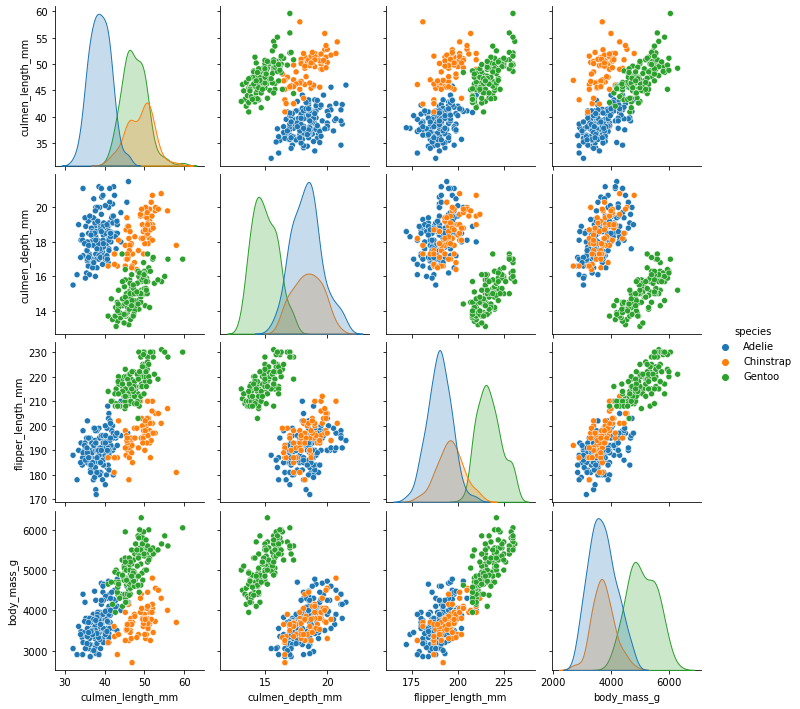

In [51]:
# %matplotlib inline
sns.pairplot(df, hue='species')

<AxesSubplot:>

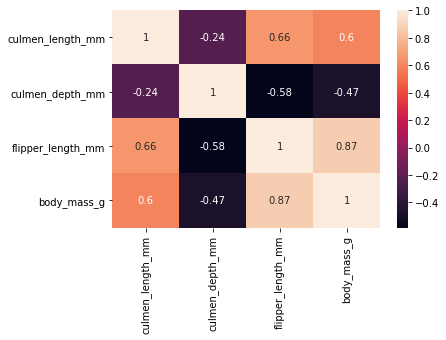

In [52]:
sns.heatmap(df.corr(), annot=True)

In [53]:
# カテゴリカルカラムのユニークな値とそれぞれの値にレコード数
cat_cols = df.select_dtypes(exclude=np.number).columns.to_list()
for cat_col in cat_cols:
    print(f"======{cat_col}======")
    print(df[cat_col].value_counts())

======species======
Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64
======island======
Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64
======sex======
MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64


In [54]:
# "."は欠損値扱いにする
df.loc[df[df['sex']=='.'].index, 'sex'] = np.nan
df[df['sex'].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


In [57]:
# それぞれの結果を格納するディクショナリー
results = {}

#### 欠損値を落とすケース

In [58]:
df.dropna(inplace=True)
target = 'species'
X = df.drop(target, axis=1)
y = df[target]

#　前処理
# ダミー変数
X = pd.get_dummies(X, drop_first=True)

# CV
from sklearn.model_selection import RepeatedKFold, cross_val_score
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_log_loss')
results['drop'] = -np.mean(scores)


In [59]:
results

{'drop': 0.030380026442626232}

#### 欠損を新カテゴリーとする(カテゴリカル変数) and 中央値で代入(数値変数)

In [77]:
df = pd.read_csv('penguins_size.csv')
# "."は欠損値扱いにする
df.loc[df[df['sex']=='.'].index, 'sex'] = np.nan
target = 'species'
X = df.drop(target, axis=1)
y = df[target]

# CV
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# ダミー変数生成クラスを自作(Pipelineに組み込むため)
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        # trainデータのカテゴリ数より
        # 推論時のtestデータのカテゴリ数が少ないとエラーとなる
        # trainデータのカテゴリでダミー変数化した場合のカラム名を保存しておく
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        # fit時に保存していた、trainデータでダミー変数化した場合のカラム名でカラムを準備
        return X_new.reindex(columns=self.columns, fill_value=0)

# Columns Transformer (imputer)
num_cols = X.select_dtypes(include=np.number).columns.to_list()
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
ct = ColumnTransformer([('imputer_cat', SimpleImputer(strategy='constant', fill_value='NaN'), cat_cols),
                  ('imputer_num', SimpleImputer(strategy='median'), num_cols)])
ct.set_output(transform='pandas')

# Pipeline (dummy + scaler + model)
pipeline = Pipeline(steps=[('ct', ct),
                           ('dummy', GetDummies()),
                           ('scaler', StandardScaler()),
                           ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_log_loss')
results['median'] = -np.mean(scores)
results

{'drop': 0.030380026442626232, 'median': 0.03241178769197841}

#### 欠損をkNNで予測したケース(カテゴリカルカラムは最頻値)

In [83]:
df = pd.read_csv('penguins_size.csv')
# "."は欠損値扱いにする
df.loc[df[df['sex']=='.'].index, 'sex'] = np.nan
target = 'species'
X = df.drop(target, axis=1)
y = df[target]

# CV
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# ダミー変数生成クラスを自作(Pipelineに組み込むため)
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        # trainデータのカテゴリ数より
        # 推論時のtestデータのカテゴリ数が少ないとエラーとなる
        # trainデータのカテゴリでダミー変数化した場合のカラム名を保存しておく
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        # fit時に保存していた、trainデータでダミー変数化した場合のカラム名でカラムを準備
        return X_new.reindex(columns=self.columns, fill_value=0)

num_pipeline = Pipeline(steps=[('scaler', StandardScaler()),('imputer_num', KNNImputer()),])

# Columns Transformer (imputer)
# num_cols = X.select_dtypes(include=np.number).columns.to_list()
# cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
ct = ColumnTransformer([('imputer_cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_exclude=np.number)),
                  ('scaler+imputer_num', num_pipeline, make_column_selector(dtype_include=np.number))])
ct.set_output(transform='pandas')

# Pipeline (dummy + scaler + model)
pipeline = Pipeline(steps=[('ct', ct),
                           ('dummy', GetDummies()),
                           ('scaler', StandardScaler()),
                           ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_log_loss')
results['knn'] = -np.mean(scores)
results


{'drop': 0.030380026442626232,
 'median': 0.03241178769197841,
 'knn': 0.03171966664514894}